# Notebook de modelagem e avaliação 

## Importação das bibliotecas

In [185]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


In [186]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

Utilizaremos os dados históricos do índice IBOVESPA, disponíveis publicamente no site do [br.investing](https://br.investing.com/indices/bovespa-historical-data)

In [187]:
input_path = '../data/processed/dados_historicos_ibovespa_2015-2025_processed.csv'

df = pd.read_csv(input_path, index_col='ds', parse_dates=['ds'])
df.tail()
df.tail()

,target,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,...,momentum_21,momentum_63,sma_21,ema_50,rsi_14,atr_14,obv,day_of_week,day_of_month,month
ds,,,,,,,,,,,,,,,,,,,,,
2025-06-12,0,137800,137127,137931,136175,7.120000e+09,0.0049,0.0051,0.0054,-0.0030,...,-0.004501,0.112510,137814.619048,134894.977670,56.429439,1746.368879,1.365131e+11,3,12,6
2025-06-13,1,137213,137800,137800,136586,8.630000e+09,-0.0043,0.0049,0.0051,0.0054,...,-0.015222,0.092138,137713.619048,134985.880507,53.149650,1708.342531,1.278831e+11,4,13,6
2025-06-16,0,139256,137212,139988,137212,7.620000e+09,0.0149,-0.0043,0.0049,0.0051,...,0.000496,0.079864,137716.904762,135153.336173,61.530240,1784.603778,1.355031e+11,0,16,6
2025-06-17,0,138840,139256,139497,138293,8.380000e+09,-0.0030,0.0149,-0.0043,0.0049,...,-0.005701,0.061192,137679.000000,135297.911225,59.207770,1743.132080,1.271231e+11,1,17,6
2025-06-18,0,138717,138844,139161,138443,8.320000e+09,-0.0009,-0.0030,0.0149,-0.0043,...,-0.009942,0.055083,137612.666667,135431.993138,58.504620,1669.908360,1.188031e+11,2,18,6


## Construção do modelo

In [188]:
# definindo variáveis preditoras e variável alvo
remove_features = ['open', 'high', 'low', 'close', 'volume', 'target', 'ema_50', 'obv']

X = df.drop(columns=remove_features)
y = df['target']

In [189]:
# divisão entre treino e teste (30 dias de pregão, conforme requisito) de forma cronológica (sem aleatoriedade)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

print(f"Tamanho do treino: {len(X_train)} amostras")
print(f"Tamanho do teste: {len(X_test)} amostras")

Tamanho do treino: 2452 amostras
Tamanho do teste: 30 amostras


Diferente dos demais modelos utilizados, a Regressão Logística (que será o modelo de baseline) e o SVM são sensíveis à escala das features. Por isso, vamos padronizar os dados para esses dois modelos. Como dados financeiros podem ter eventos extremos em épocas de crise, escolhemos o método de escalonamento do `StandardScaler()`, pois é mais robusto a outliers.

In [190]:
# definindo modelos de classificação
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42, n_jobs=-1))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=42))
    ]),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
}

In [191]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Logistic Regression...
Treinando SVM...
Treinando Decision Tree...
Treinando Random Forest...
Treinando XGBoost...
Todos os modelos foram treinados!


In [192]:
# comparando o desempenho dos modelos
performance = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance.loc[performance.shape[0]] = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }
performance.set_index("Model", inplace=True)
performance = performance.map(lambda x: f"{100 * x:2.2f} %")
performance.sort_values("F1-Score", ascending=False, inplace=True)

performance

,Accuracy,Precision,Recall,F1-Score
Model,,,,
SVM,66.67 %,67.33 %,66.67 %,65.74 %
Random Forest,63.33 %,63.38 %,63.33 %,62.70 %
Logistic Regression,60.00 %,60.54 %,60.00 %,60.00 %
XGBoost,56.67 %,56.81 %,56.67 %,53.33 %
Decision Tree,43.33 %,42.23 %,43.33 %,42.36 %


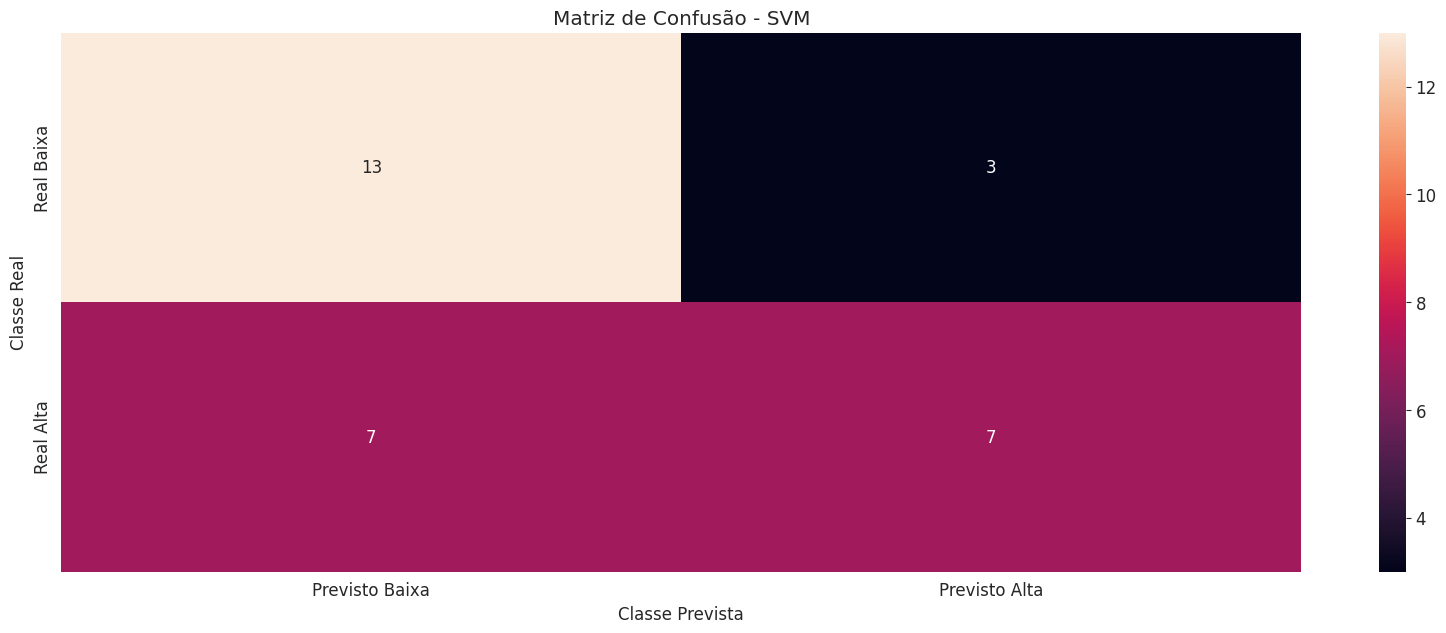

In [202]:
# matriz de confusão para o melhor modelo
best_model_name = performance.idxmax().iloc[0]
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

O modelo acerta muito bem a classe "Baixa", mas tem dificuldade de prever a classe "Alta".

## Validação cruzada

A validação cruzada ajuda a garantir que o modelo não está sobreajustado aos dados de treinamento e terá um bom desempenho em dados novos. 

In [194]:
tscv = TimeSeriesSplit(n_splits=5)

# conferir performance do SVM nos folds de validação cruzada
cv_scores = cross_val_score(models['SVM'], X_train, y_train, cv=tscv, scoring='accuracy')

print("Acurácia do SVM Padrão em cada fold:")
print(cv_scores)
print(f"\nMédia da acurácia na validação: {cv_scores.mean():.2%}")

Acurácia do SVM Padrão em cada fold:
[0.5122549  0.50735294 0.50490196 0.46813725 0.53921569]

Média da acurácia na validação: 50.64%


## Seleção das features

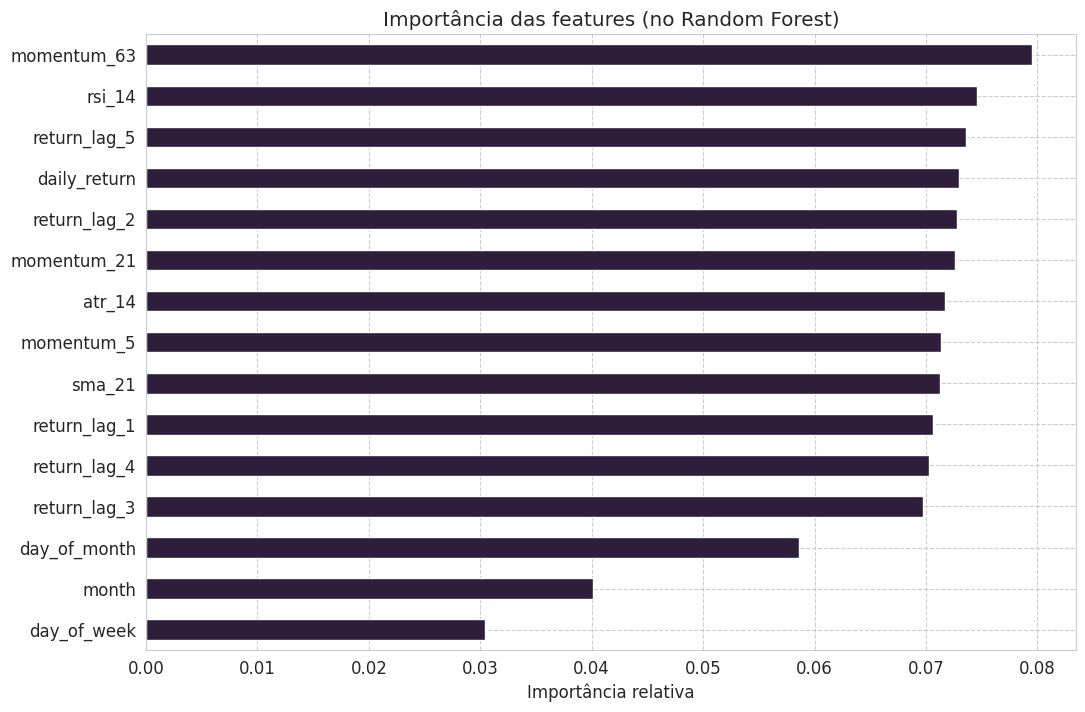

In [195]:
importance = pd.Series(models['Random Forest'].feature_importances_, index=X_train.columns)

# plotando as features mais importantes
plt.figure(figsize=(12, 8))
importance.nlargest(20).sort_values().plot(kind='barh')
plt.title('Importância das features (no Random Forest)')
plt.xlabel('Importância relativa')
plt.show()

In [196]:
importance_threshold = 0.05 

# filtrar as features que atendem ao critério
relevant_features = importance[importance > importance_threshold]
selected_features = relevant_features.index

print(f"Número de features original: {len(importance)}")
print(f"Número de features após seleção com limiar de {importance_threshold}: {len(relevant_features)}")
print("\nFeatures que serão mantidas para a otimização:")
print(list(selected_features))

Número de features original: 15
Número de features após seleção com limiar de 0.05: 13

Features que serão mantidas para a otimização:
['daily_return', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5', 'momentum_5', 'momentum_21', 'momentum_63', 'sma_21', 'rsi_14', 'atr_14', 'day_of_month']


In [197]:
# dividir treino e teste novamente com as novas features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

## Ajuste de hiperparâmetros

In [198]:
# hiperparâmetros que iremos testar
# usamos 'model__parametro' por causa do pipeline
param_grid_svm = {
    'model__C': [0.1, 1, 5],
    'model__gamma': ['scale', 'auto', 0.1, 0.5],
    'model__kernel': ['rbf']
}

# configuração do GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=models['SVM'],
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_svm.fit(X_train_selected, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.1, 1, ...], 'model__gamma': ['scale', 'auto', ...], 'model__kernel': ['rbf']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [199]:
# análise dos resultados
print("Melhores parâmetros para o SVM: ", grid_search_svm.best_params_)
print("Melhor acurácia na validação cruzada do SVM: {:.2%}".format(grid_search_svm.best_score_))

Melhores parâmetros para o SVM:  {'model__C': 1, 'model__gamma': 0.5, 'model__kernel': 'rbf'}
Melhor acurácia na validação cruzada do SVM: 52.55%


In [200]:
# melhor SVM no conjunto de teste
best_svm = grid_search_svm.best_estimator_
pred_test = best_svm.predict(X_test_selected)

print("Relatório de classificação do SVM:\n")
print(classification_report(y_test, pred_test))

Relatório de classificação do SVM:

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        16
           1       0.56      0.71      0.62        14

    accuracy                           0.60        30
   macro avg       0.61      0.61      0.60        30
weighted avg       0.61      0.60      0.60        30

